In [1]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, RidgeCV
from yellowbrick.regressor import prediction_error, ResidualsPlot

In [2]:
# Load the DataFrame from the Excel file
file_path = 'STADS_removedActivityCliffs_ECFP42048.xlsx'
df = pd.read_excel(file_path)

In [3]:
# Define the columns you want to drop
columns_to_drop = {'chi4v', 'chi2v', 'NumUnspecifiedAtomStereoCenters', 'NumAliphaticHeterocycles', 
                   'NumRings', 'NumHeavyAtoms', 'NumHeteroatoms', 'lipinskiHBA', 'chi3v', 
                   'labuteASA', 'CrippenMR', 'chi0v', 'Phi', 'kappa1', 'NumSaturatedHeterocycles', 
                   'lipinskiHBAHBD', 'NumAtoms', 'Total Surface Area', 'chi1v', 'NumBridgeheadAtoms'}

# Drop the columns from the DataFrame
df = df.drop(columns=columns_to_drop, errors='ignore')

print(df.shape)
df.head(1)

(209, 25)


,NEW_SMILES,pIC50,amw,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,FractionCSP3,NumAromaticRings,...,NumAtomStereoCenters,tpsa,CrippenClogP,hallKierAlpha,kappa2,kappa3,Shape Index,Molecular Flexibility,Molecular Complexity,fp
0,CC(=O)N(C)Cc1cc(C(=O)N(C)Cc2cc3ccccc3n2C)ccc1N,5.173925,378.476,2,5,1,4,2,0.272727,3,...,0,71.57,3.011,-3.28,7.760914,3.856356,0.53571,0.608,0.81905,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
print(df.columns)

Index(['NEW_SMILES', 'pIC50', 'amw', 'lipinskiHBD', 'NumRotatableBonds',
       'NumHBD', 'NumHBA', 'NumAmideBonds', 'FractionCSP3', 'NumAromaticRings',
       'NumAliphaticRings', 'NumSaturatedRings', 'NumHeterocycles',
       'NumAromaticHeterocycles', 'NumSpiroAtoms', 'NumAtomStereoCenters',
       'tpsa', 'CrippenClogP', 'hallKierAlpha', 'kappa2', 'kappa3',
       'Shape Index', 'Molecular Flexibility', 'Molecular Complexity', 'fp'],
      dtype='object')


In [5]:
# Remove specified columns from the dataframe
df = df.drop(columns = ['NEW_SMILES'])

In [6]:
print(df.columns)

Index(['pIC50', 'amw', 'lipinskiHBD', 'NumRotatableBonds', 'NumHBD', 'NumHBA',
       'NumAmideBonds', 'FractionCSP3', 'NumAromaticRings',
       'NumAliphaticRings', 'NumSaturatedRings', 'NumHeterocycles',
       'NumAromaticHeterocycles', 'NumSpiroAtoms', 'NumAtomStereoCenters',
       'tpsa', 'CrippenClogP', 'hallKierAlpha', 'kappa2', 'kappa3',
       'Shape Index', 'Molecular Flexibility', 'Molecular Complexity', 'fp'],
      dtype='object')


In [7]:
# Display the new DataFrame
print(df.head(1))
print(df.shape)

      pIC50      amw  lipinskiHBD  NumRotatableBonds  NumHBD  NumHBA  \
0  5.173925  378.476            2                  5       1       4   

   NumAmideBonds  FractionCSP3  NumAromaticRings  NumAliphaticRings  ...  \
0              2      0.272727                 3                  0  ...   

   NumAtomStereoCenters   tpsa  CrippenClogP  hallKierAlpha    kappa2  \
0                     0  71.57         3.011          -3.28  7.760914   

     kappa3  Shape Index  Molecular Flexibility  Molecular Complexity  \
0  3.856356      0.53571                  0.608               0.81905   

                                                  fp  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[1 rows x 24 columns]
(209, 24)


In [8]:
# Apply ast.literal_eval only if the element is a string
df['fp'] = df['fp'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else np.array(x))

# Extract features and target variable
X = np.stack(df['fp'].values)
y = df['pIC50'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10001010)

## Ridge Linear Regression

In [36]:
# Initialize RidgeCV with multiple alpha values to perform Ridge regression with cross-validation.
# The `alphas` parameter specifies a range of values for the regularization strength.
# `cv=10` specifies that 10-fold cross-validation is used to evaluate each alpha.
ridge_cv = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 3, 4, 5, 5.5, 6, 10, 10.5, 12, 13, 15, 15.5, 18, 20, 20.5, 25, 25.5], cv=10).fit(X_train, y_train)

# Output the best alpha value determined by cross-validation, which provides the optimal balance
# between complexity and performance of the model.
print(f"Best alpha: {ridge_cv.alpha_}")


Best alpha: 13.0


In [ ]:
# Define the Ridge regression model without scaling
ridge_model = Ridge()

# Define the hyperparameters to search over
param_grid = {
    'alpha': np.logspace(-3, 3, 13),  # Search alphas from 0.001 to 1000 in log scale
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Output the best hyperparameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation R² score: {grid_search.best_score_}")

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)


In [10]:
# Fit the Ridge regression model using the scaled features
ridge = Ridge(alpha=10, fit_intercept=True, solver='saga') 
ridge.fit(X_train, y_train)

# Get predictions for both training and test sets
train_predictions = ridge.predict(X_train)
predictions = ridge.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2_test = r2_score(y_test, predictions)
r2_train = r2_score(y_train, train_predictions)

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(y_test, predictions)
spearman_train, _ =spearmanr(y_train, train_predictions)
# Print performance metrics and Spearman correlation
print(f"The mean absolute error: {mae}")
print(f"The root mean squared error: {rmse}")
print(f"Spearman correlation on test set: {spearman_corr}")
print(f"Spearman correlation on train set: {spearman_train}")

The mean absolute error: 0.3900818343231834
The root mean squared error: 0.46711618205483557
Spearman correlation on test set: 0.9019615794870295
Spearman correlation on train set: 0.9278409910730491


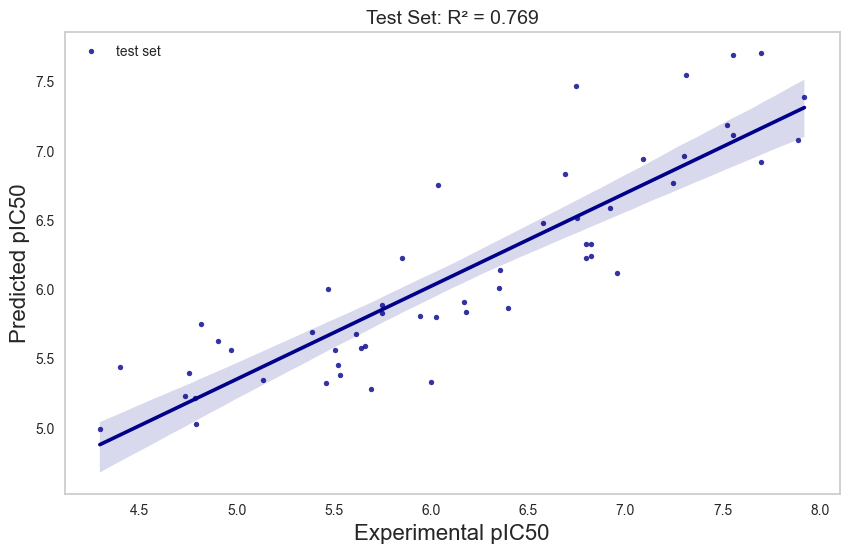

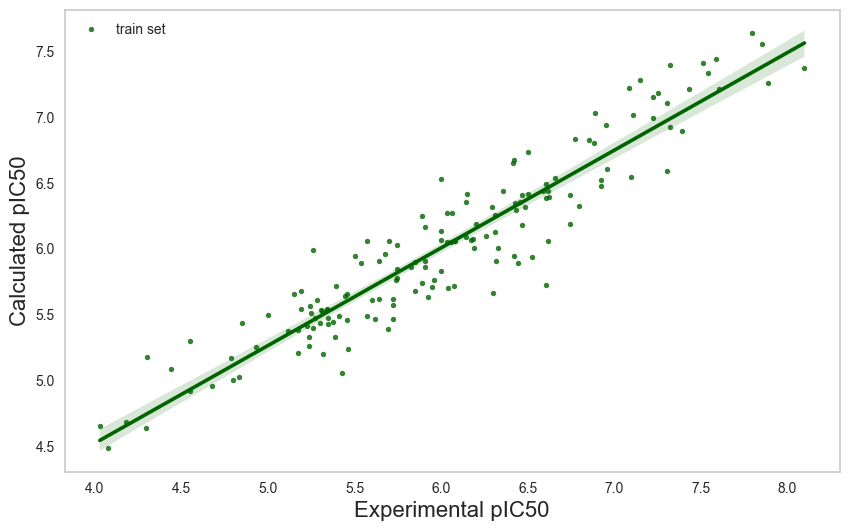

In [13]:
# predicted values:
train_predictions = ridge.predict(X_train)
test_predictions = ridge.predict(X_test)

# Calculate R^2 for training and test sets
r2_train = r2_score(y_train, train_predictions)
r2_test = r2_score(y_test, test_predictions)

# Plot predictions vs actual for the test set
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=y_test, y=test_predictions, scatter_kws={'s':15}, color='darkblue', label='test set')  # label='Test Set'

# Set labels and title
ax.set_xlabel("Experimental pIC50", fontsize=16)  # Set x-axis label with font size
ax.set_ylabel("Predicted pIC50", fontsize=16)  # Set y-axis label with font size
plt.title(f"Test Set: R² = {r2_test:.3f}", fontsize=14)  # Set title with font size
ax.grid(False)
# Display the plot for the test set
plt.legend()
plt.show()

# Plot predictions vs actual for the training set
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=y_train, y=train_predictions, scatter_kws={'s':15}, color='darkgreen', label='train set') #label='train Set'

# Set labels and title
ax.set_xlabel("Experimental pIC50", fontsize=16)  # Set x-axis label with font size
ax.set_ylabel("Calculated pIC50", fontsize=16) 
ax.grid(False)
# Display the plot for the training set
plt.legend()
plt.show()

In [12]:
# Define a custom scoring function for Spearman correlation
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]  # Only return the correlation coefficient

# Create a scorer based on the custom Spearman function
spearman_scorer = make_scorer(spearman_corr, greater_is_better=True)

# Perform cross-validation with 5 folds using the Spearman correlation as the scoring metric
cv_scores_spearman = cross_val_score(ridge, X_train, y_train, cv=5, scoring=spearman_scorer)

# Print the cross-validation Spearman correlation scores
print(f"Cross-Validation Spearman Correlation Scores: {cv_scores_spearman}")
print(f"Mean Cross-Validation Spearman Correlation Score: {cv_scores_spearman.mean()}")


Cross-Validation Spearman Correlation Scores: [0.57195235 0.60812582 0.8143779  0.78306452 0.73454986]
Mean Cross-Validation Spearman Correlation Score: 0.7024140883177837


In [53]:
# Set up Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Use MSE as the scoring function for LOOCV
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform LOOCV using MSE as the scoring metric
loocv_scores = cross_val_score(ridge, X, y, cv=loo, scoring=mse_scorer)

# Calculate the mean MSE score from LOOCV (note that cross_val_score returns negative MSE values)
mean_loocv_mse = -loocv_scores.mean()

# Output the LOOCV MSE scores and the mean MSE score
#print(f"LOOCV MSE scores: {loocv_scores}")
print(f"Mean LOOCV MSE score: {mean_loocv_mse}")

Mean LOOCV MSE score: 0.2926596827676602


### **Making prediction of new data on trained model**

In [47]:
# Prepare the dataset
new_file_path = 'file with compounds generated by transformation rules.txt'  # Replace with your actual file path
new_df = pd.read_csv(new_file_path)

In [48]:
# Define the columns you want to drop
columns_to_drop = {'chi4v', 'chi2v', 'NumUnspecifiedAtomStereoCenters', 'NumAliphaticHeterocycles', 
                   'NumRings', 'NumHeavyAtoms', 'NumHeteroatoms', 'lipinskiHBA', 'chi3v', 
                   'labuteASA', 'CrippenMR', 'chi0v', 'Phi', 'kappa1', 'NumSaturatedHeterocycles', 
                   'lipinskiHBAHBD', 'NumAtoms', 'Total Surface Area', 'chi1v', 'NumBridgeheadAtoms'}

# Drop the columns from the DataFrame
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')

print(df.shape)
new_df.head(1)

(209, 24)


,NEW_SMILES,Shape Index,Molecular Flexibility,Molecular Complexity,amw,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,...,NumHeterocycles,NumAromaticHeterocycles,NumSpiroAtoms,NumAtomStereoCenters,tpsa,CrippenClogP,hallKierAlpha,kappa2,kappa3,fp
0,Oc1ccc(C=C2CCc3c(n(Cc4ccc(O)cc4)c4ccccc34)C2)cc1,0.55172,0.33101,0.88694,381.475,2,3,2,3,0,...,1,1,0,0,45.39,5.6731,-3.46,7.173162,3.401712,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [49]:
if 'fp' in new_df.columns:
    new_df['fp'] = new_df['fp'].apply(ast.literal_eval)
    new_df['fp'] = new_df['fp'].apply(lambda x: np.array(x))

In [50]:
# Step 3: Use the Trained Model to Make Predictions on the New Dataset
X_new = np.stack(new_df['fp'].values)
predictions_new = ridge.predict(X_new)

In [51]:
#Assign Predicted pIC50 Values to Respective SMILES
new_df = new_df.copy()
new_df['Predicted_pIC50'] = predictions_new
print(new_df[['NEW_SMILES', 'Predicted_pIC50']].head())
print(len(new_df))
print(len(new_df.shape))

                                          NEW_SMILES  Predicted_pIC50
0   Oc1ccc(C=C2CCc3c(n(Cc4ccc(O)cc4)c4ccccc34)C2)cc1         5.668976
1  N=C(c1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3ccccc...         5.720242
2  O=C(Oc1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3cccc...         6.072160
3  O=C(Nc1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3cccc...         5.744659
4  O=C(Sc1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3cccc...         5.813325
172026
2


In [52]:
new_df.to_csv('Save your file.txt', index=False)


In [53]:
# Analyze predicted pIC50 values
print(new_df['Predicted_pIC50'].describe())


count    172026.000000
mean          5.943694
std           0.372374
min           4.780570
25%           5.704116
50%           5.894186
75%           6.112786
max           7.798237
Name: Predicted_pIC50, dtype: float64


Plotting Predicted pIC50 Values vs. Molecule ID